# <div style="color:white;display:fill;border-radius:5px;background-color:#F28482;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">Data Preparation</p></div> 

In [3]:
import numpy as np
import pandas as pd
import datetime
import os
import warnings

from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from lightgbm import LGBMRegressor

import optuna
import shap


import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# <div style="color:white;display:fill;border-radius:5px;background-color:#F28482;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">Data Extracting</p></div> 

In [4]:
current_dir = os.getcwd()

ROOT_DIR = os.path.abspath(os.path.join(current_dir, '..'))
DATA_PROCESSED_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'kc_house_data_processed.csv')

In [5]:
#Reading raw data
df_raw = pd.read_csv(DATA_PROCESSED_PATH)

In [6]:
df = df_raw.copy()
df.shape

(21434, 27)

In [7]:
df.zipcode.nunique()

70

In [8]:
imputer = SimpleImputer(strategy='mean')

imputer.fit(df[['sqft_above']])
df['sqft_above'] = imputer.transform(df[['sqft_above']])

# <div style="color:white;display:fill;border-radius:5px;background-color:#F28482;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">SELECTED FEATURES</p></div>

In [9]:
TARGET = 'price' 

SELECTED_FEATURES = [#'id', 
                     #'date', 
                     'bedrooms', 
                     'bathrooms', 
                     'sqft_living',
                     'sqft_lot',
                     'floors',
                     'waterfront',
                     'view',
                     'condition',
                     'grade',
                     'sqft_above',
                     'sqft_basement',
                     'yr_built',
                     'yr_renovated',
                     #'zipcode',
                     'lat',
                     'long',
                     'sqft_living15',
                     'sqft_lot15',
                     'year',
                     'month',
                     'weekday',
                     #'day',
                     #'house_age',
                     #'price_sqft2',
                     #'season'
                    ]

# <div style="color:white;display:fill;border-radius:5px;background-color:#F28482;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">Dealing with Outliers</p></div> 

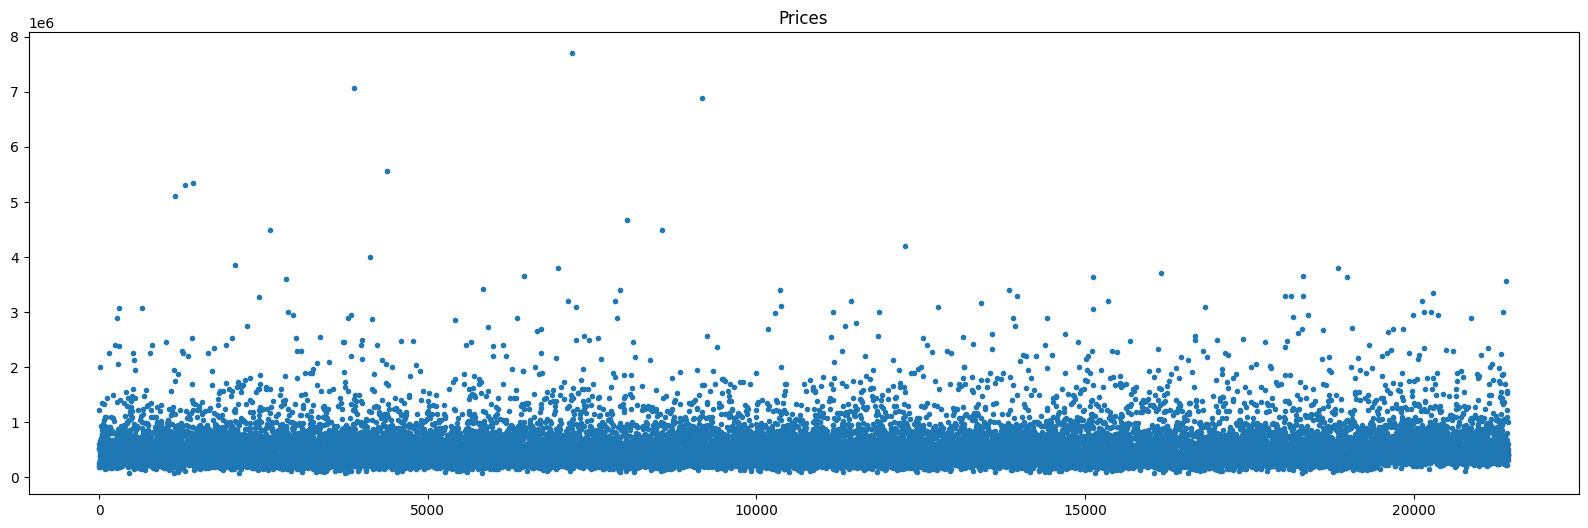

In [10]:
df['price'].plot(style='.', figsize=(20, 6), title='Prices');

In [11]:
#Removing a coupple of Outliers
isfo = IsolationForest(contamination=0.01)#, max_samples = 100, random_state = 42)
isfo.fit(df[SELECTED_FEATURES])

isfo_pred = isfo.predict(df[SELECTED_FEATURES])
df_aux = pd.DataFrame(isfo_pred, columns = ['anomaly'])
df_aux['anomaly'].value_counts(normalize=True), df_aux['anomaly'].value_counts()

(anomaly
  1    0.989969
 -1    0.010031
 Name: proportion, dtype: float64,
 anomaly
  1    21219
 -1      215
 Name: count, dtype: int64)

In [12]:
df = df.iloc[df_aux[df_aux['anomaly'] == 1].index.values].reset_index(drop=True)

# <div style="color:white;display:fill;border-radius:5px;background-color:#F28482;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">Dealing with Skewness</p></div>

In [13]:
aux = [col for col in SELECTED_FEATURES if col not in ['lat', 'long']]

log_columns = df[aux].skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]
log_columns

waterfront       14.464588
sqft_lot         12.182990
sqft_lot15        8.072203
yr_renovated      4.685558
view              3.537815
sqft_basement     1.411418
sqft_above        1.226190
condition         1.039838
sqft_living15     1.034329
sqft_living       1.008074
year              0.753100
dtype: float64

In [14]:
for col in log_columns.index:
          df[col] = np.log1p(df[col])

In [15]:
y = df[TARGET]
X = df[SELECTED_FEATURES]

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle=True)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14853, 20), (14853,), (6366, 20), (6366,))

In [17]:
n_splits = 5    
Kfold = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED )

In [18]:
lgbm = LGBMRegressor(objective='regression', verbose=-1, random_state=RANDOM_SEED)

In [19]:
y_pred = cross_val_predict(lgbm, X, y, cv=Kfold, verbose=False)    
#y_prob = y_prob[:,1]    
#threshold = 0.5    
y_pred

array([233758.28237886, 483936.9992435 , 318641.63659159, ...,
       320934.1451893 , 411275.99715282, 314779.04669286])

In [20]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Criando um scorer a partir da função MAPE
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Definindo as métricas de regressão que deseja calcular, incluindo o MAPE
scoring = {'neg_mean_squared_error': 'neg_mean_squared_error',
           'neg_mean_absolute_error': 'neg_mean_absolute_error',
           'r2': 'r2',
           'mape': mape_scorer}


scores = cross_validate(lgbm, X, y, cv = Kfold, scoring=scoring, return_train_score=True)
scores

{'fit_time': array([0.13199806, 0.09999967, 0.10100245, 0.10999966, 0.10700154]),
 'score_time': array([0.0079987 , 0.00699997, 0.00800085, 0.00800204, 0.0070014 ]),
 'test_neg_mean_squared_error': array([-1.20143222e+10, -1.27064728e+10, -9.39995220e+09, -1.00835883e+10,
        -1.11333061e+10]),
 'train_neg_mean_squared_error': array([-5.85052383e+09, -5.88290102e+09, -6.05121381e+09, -6.01751763e+09,
        -5.91006889e+09]),
 'test_neg_mean_absolute_error': array([-62452.39637581, -65062.05504624, -61145.10818468, -61854.33479042,
        -63024.7110298 ]),
 'train_neg_mean_absolute_error': array([-51906.39795041, -51997.55093874, -52619.06090537, -52398.27317958,
        -52180.39506076]),
 'test_r2': array([0.89195839, 0.88722066, 0.90613133, 0.90103128, 0.88493391]),
 'train_r2': array([0.94313887, 0.94261409, 0.9427245 , 0.94281147, 0.94451116]),
 'test_mape': array([-11.94998649, -12.40521037, -12.64659551, -12.29657533,
        -12.35889378]),
 'train_mape': array([-11.0396

In [21]:
xx = pd.DataFrame.from_dict(scores)
xx
# df['value'] = df.mean(axis=1)
# df['std'] = df.std(axis=1)
# display(df[['value','std']])

,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2,test_mape,train_mape
0,0.131998,0.007999,-1.201432e+10,-5.850524e+09,-62452.396376,-51906.397950,0.891958,0.943139,-11.949986,-11.039688
1,0.100000,0.007000,-1.270647e+10,-5.882901e+09,-65062.055046,-51997.550939,0.887221,0.942614,-12.405210,-11.068297
2,0.101002,0.008001,-9.399952e+09,-6.051214e+09,-61145.108185,-52619.060905,0.906131,0.942724,-12.646596,-11.019307
3,0.110000,0.008002,-1.008359e+10,-6.017518e+09,-61854.334790,-52398.273180,0.901031,0.942811,-12.296575,-11.071547
4,0.107002,0.007001,-1.113331e+10,-5.910069e+09,-63024.711030,-52180.395061,0.884934,0.944511,-12.358894,-11.019721


In [22]:
# Calculando as médias das métricas para o conjunto de teste
mean_mse_test = -scores['test_neg_mean_squared_error'].mean()
mean_mae_test = -scores['test_neg_mean_absolute_error'].mean()
mean_r2_test = scores['test_r2'].mean()
mean_mape_test = -scores['test_mape'].mean()

# Calculando os desvios padrão das métricas para o conjunto de teste
std_mse_test = scores['test_neg_mean_squared_error'].std()
std_mae_test = scores['test_neg_mean_absolute_error'].std()
std_r2_test = scores['test_r2'].std()
std_mape_test = -scores['test_mape'].std()

# Calculando as médias das métricas para o conjunto de treinamento
mean_mse_train = -scores['train_neg_mean_squared_error'].mean()
mean_mae_train = -scores['train_neg_mean_absolute_error'].mean()
mean_r2_train = scores['train_r2'].mean()
mean_mape_train = -scores['train_mape'].mean()

# Calculando os desvios padrão das métricas para o conjunto de treinamento
std_mse_train = scores['train_neg_mean_squared_error'].std()
std_mae_train = scores['train_neg_mean_absolute_error'].std()
std_r2_train = scores['train_r2'].std()
std_mape_train = -scores['train_mape'].std()

# Exibindo as métricas para o conjunto de teste com média e desvio padrão
print("Conjunto de Teste:")
print("Média MSE: {:.4f} ± {:.4f}".format(mean_mse_test, std_mse_test))
print("Média MAE: {:.4f} ± {:.4f}".format(mean_mae_test, std_mae_test))
print("Média R2: {:.4f} ± {:.4f}".format(mean_r2_test, std_r2_test))
print("Média MAPE: {:.4f} ± {:.4f}".format(mean_mape_test, std_mape_test))

# Exibindo as métricas para o conjunto de treinamento com média e desvio padrão
print("\nConjunto de Treinamento:")
print("Média MSE: {:.4f} ± {:.4f}".format(mean_mse_train, std_mse_train))
print("Média MAE: {:.4f} ± {:.4f}".format(mean_mae_train, std_mae_train))
print("Média R2: {:.4f} ± {:.4f}".format(mean_r2_train, std_r2_train))
print("Média MAPE: {:.4f} ± {:.4f}".format(mean_mape_train, std_mape_train))


Conjunto de Teste:
Média MSE: 11067528330.0364 ± 1211266479.3342
Média MAE: 62707.7211 ± 1332.5606
Média R2: 0.8943 ± 0.0081
Média MAPE: 12.3315 ± -0.2246

Conjunto de Treinamento:
Média MSE: 5942445036.3322 ± 78114986.6264
Média MAE: 52220.3356 ± 260.9325
Média R2: 0.9432 ± 0.0007
Média MAPE: 11.0437 ± -0.0227


# <div style="color:white;display:fill;border-radius:5px;background-color:#F28482;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">Hypertuning</p></div> 

In [23]:
def objective(trial):
    
 
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['regression']),        
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']), 
        "num_leaves": trial.suggest_int("num_leaves", 100, 300, step=20),
        "max_depth": trial.suggest_int("max_depth", 6, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1.0, log=True),
        #'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        #'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'verbosity': trial.suggest_categorical('verbosity', [-1]),
        #'metric': trial.suggest_categorical('metric', ['auc']), 
        #'eval_metric': trial.suggest_categorical('eval_metric', ['f1']),   
        #"metric": "binary_error",
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.9),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 0.9),
        #'is_unbalance': trial.suggest_categorical('is_unbalance', [False,True]),
        #'boost_from_average': trial.suggest_categorical('boost_from_average', [False,True]),
        #'early_stopping_rounds':10,
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED])      
        
    }
    
    model = LGBMRegressor(**param_grid)
    
    n_splits = 3
    Kfold = KFold(n_splits=n_splits, shuffle=True)#random_state=RANDOM_SEED
    #scores = cross_val_score(model, X, y, cv=Kfold, scoring="precision")
    #return scores.mean()
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    
    #return mean_absolute_percentage_error(y,y_pred)
    return mean_absolute_error(y,y_pred)

In [24]:
study = optuna.create_study(direction='minimize')
#optuna.logging.set_verbosity(optuna.logging.WARNING) 
#optuna.logging.set_verbosity(optuna.logging.DEBUG) 
study.optimize(objective, n_trials=100);

trial = study.best_trial

[I 2024-04-25 11:36:48,040] A new study created in memory with name: no-name-718c1ab5-ab86-49bc-9a9e-b51b82c948be
[I 2024-04-25 11:36:48,791] Trial 0 finished with value: 173508.93994775513 and parameters: {'objective': 'regression', 'boosting_type': 'gbdt', 'num_leaves': 120, 'max_depth': 8, 'learning_rate': 0.0029120820169057184, 'reg_alpha': 6.45671545881543e-07, 'reg_lambda': 0.00026198591128198196, 'verbosity': -1, 'seed': 42}. Best is trial 0 with value: 173508.93994775513.
[I 2024-04-25 11:36:49,642] Trial 1 finished with value: 62505.33966515907 and parameters: {'objective': 'regression', 'boosting_type': 'gbdt', 'num_leaves': 140, 'max_depth': 14, 'learning_rate': 0.06678391047238598, 'reg_alpha': 2.863808295807472e-05, 'reg_lambda': 1.2389011247344567e-05, 'verbosity': -1, 'seed': 42}. Best is trial 1 with value: 62505.33966515907.
[I 2024-04-25 11:36:50,524] Trial 2 finished with value: 273563.7342505851 and parameters: {'objective': 'regression', 'boosting_type': 'dart', 'n

In [25]:
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best Score: {lgbm_best_score}\n\n")
print("Optimized Parameters:\n")
for key, value in lgbm_best_params.items():
    print(f"{key}: {value}")

Best Score: 61634.88623098921


Optimized Parameters:

objective: regression
boosting_type: gbdt
num_leaves: 180
max_depth: 13
learning_rate: 0.08176328486719492
reg_alpha: 4.441336586372244e-08
reg_lambda: 0.000634781448328293
verbosity: -1
seed: 42


In [26]:
lgbm = LGBMRegressor(**lgbm_best_params)

In [27]:
import joblib

LGBM_MODEL_PATH = os.path.join(ROOT_DIR, 'models', 'lgbm.joblib')
joblib.dump(lgbm, LGBM_MODEL_PATH)

['c:\\Users\\Alysson\\Documents\\Projects\\Study-KC-House-Prices\\models\\lgbm.joblib']

In [28]:
xxx = joblib.load(LGBM_MODEL_PATH)

In [29]:
xxx

LGBMRegressor(learning_rate=0.08176328486719492, max_depth=13, num_leaves=180,
              objective='regression', reg_alpha=4.441336586372244e-08,
              reg_lambda=0.000634781448328293, seed=42, verbosity=-1)

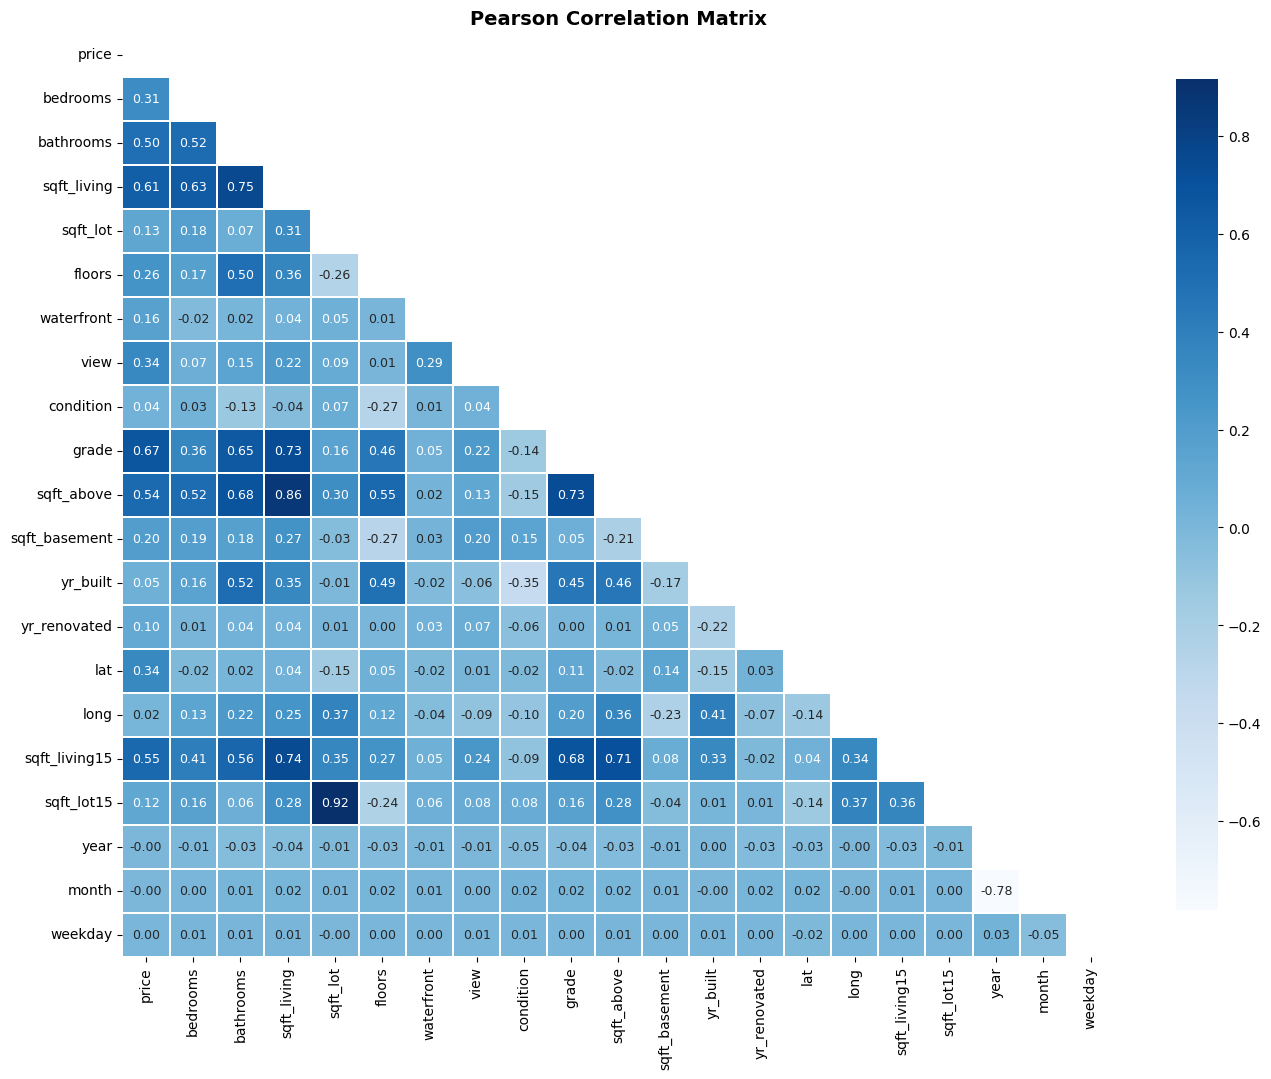

In [30]:
aux = pd.concat([y,X], axis=1)

mask = np.zeros_like(aux.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=14, fontweight='bold')
sns.heatmap(aux.corr(method='pearson'), linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

In [31]:
shap.initjs()

In [32]:
lgbm.fit(X, y)
explainer = shap.Explainer(lgbm, X)
shap_values = explainer(X)

100%|===================| 21161/21219 [02:34<00:00]        

In [77]:
#300 Not Canceled, Resort Hotel, Parking Required - Acertou
#96 Canceled, Native, Special Request - Acertou
#138,630 Canceled,
#630 Canceled
#120 Not Canceled, Resort Hotel, Native
#151 Not Canceled, Resort Hotel, No Native
#96655 Not Canceled, City Hotel, No Native
#95241 Not Canceled City Hotel, No Native
idx = 2567


df.iloc[idx,:]

id               3275890310
date             2015-02-12
price              677100.0
bedrooms                  3
bathrooms               2.0
sqft_living        7.654917
sqft_lot           9.126959
floors                  1.0
waterfront              0.0
view                    0.0
condition          1.386294
grade                    10
sqft_above         7.654917
sqft_basement           0.0
yr_built               1993
yr_renovated            0.0
zipcode               98074
lat                 47.6496
long               -122.083
sqft_living15      8.049108
sqft_lot15         9.087268
year               7.608871
month                     2
day                      12
weekday                   4
house_age                22
price_sqft2           320.9
season               Winter
Name: 2567, dtype: object

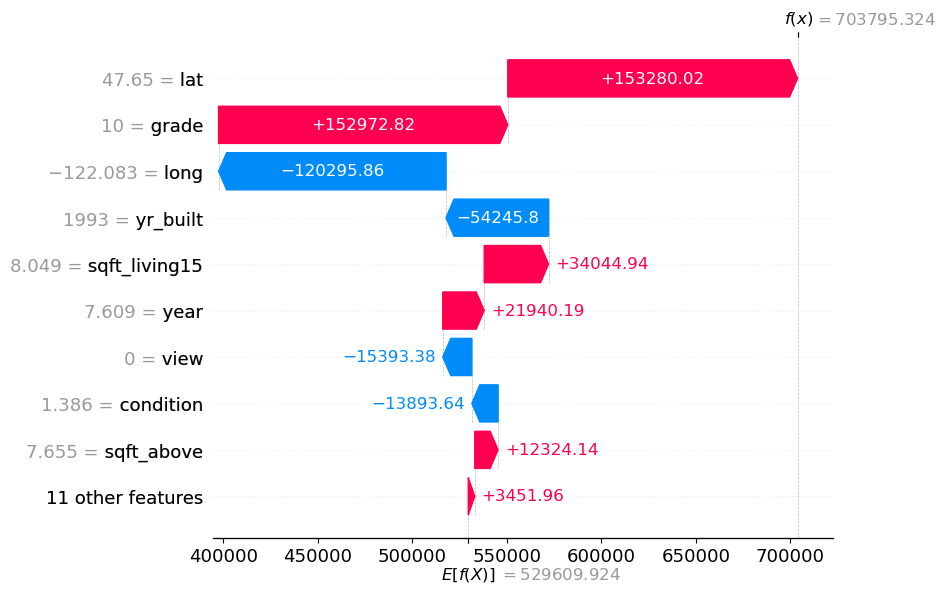

In [79]:
shap.plots.waterfall(shap_values[idx,:])

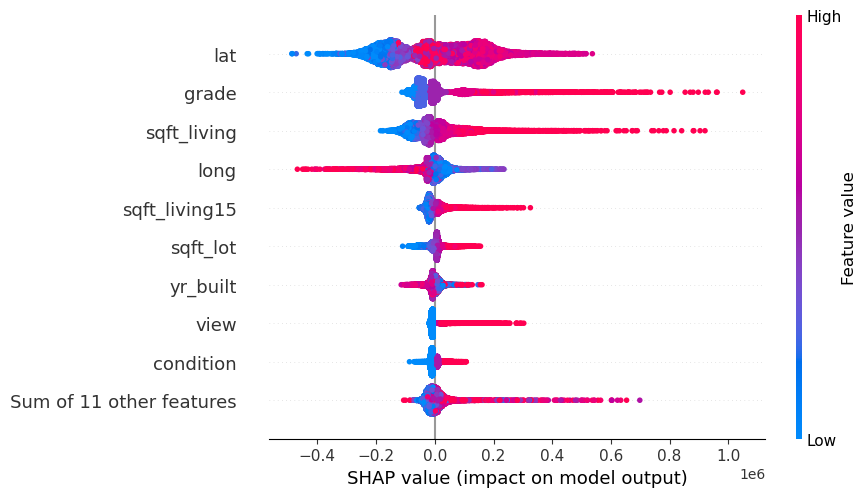

In [80]:
shap.plots.beeswarm(shap_values)

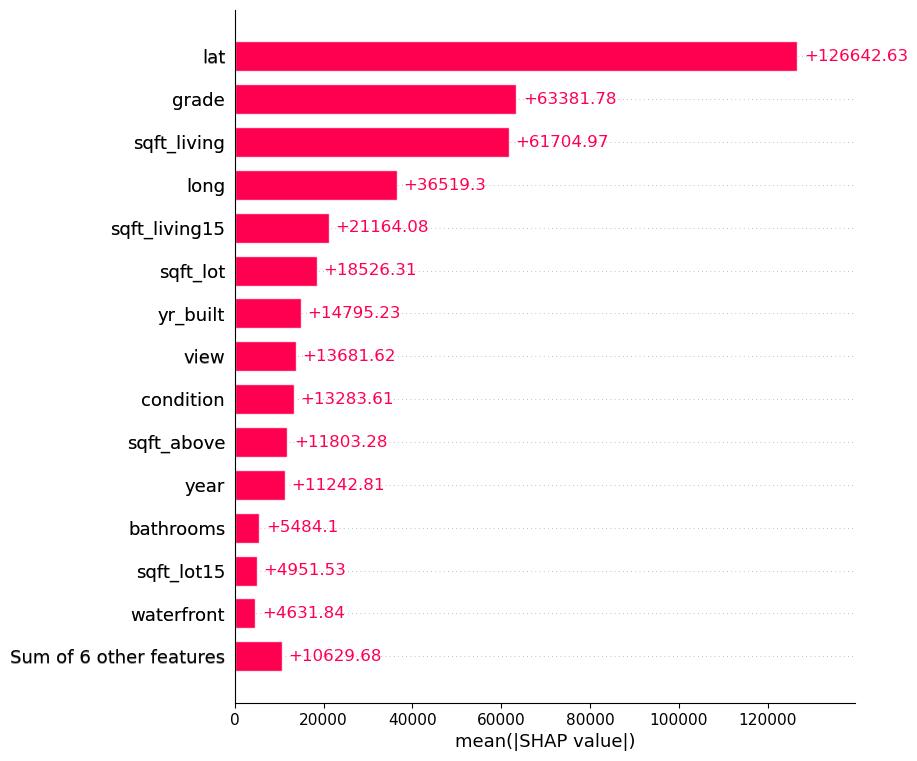

In [86]:
shap.plots.bar(shap_values, max_display=15)